# Introduction

In this notebook, we will perform an exploratory data analysis (EDA) on a combat dataset created by Manuel Cota. This work is aimed at classifying the difficulty of battles between the parties of heroes and the monsters in Dungeons & Dragons (D&D).

The dataset includes detailed information on the heroes and monsters involved in each encounter:

- **Heroes Data:**  
  Each hero is described by a block of 10 columns, which include the hero's class, level, and various attributes such as HP, AC, and ability scores (STR, DEX, CON, INT, WIS, CHA).
  
- **Monsters Data:**  
  The data for monsters is organized into blocks as well, with each monster having a name, a challenge rating (`cr`), and a set of attributes similar to the heroes. In our dataset, there are up to three monsters per encounter.

- **Encounter Metrics:**  
  Additional columns such as `not_conscious_players_ratio`, `party_hp_ratio`, and `difficulty` offer further insights into the state of the encounter.

Throughout this analysis, we will explore various aspects of the data, including distribution of attributes, relationships between party composition and encounter outcome, and the overall difficulty of battles. The insights derived from this EDA will help us understand the factors that contribute to encounter difficulty in D&D.


In [1]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

In [2]:
FORESIGHT_DIRECTORY = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

DATA_RAW_DIRECTORY = os.path.join(FORESIGHT_DIRECTORY, "data", "raw")
DATA_INTERIM_DIRECTORY = os.path.join(FORESIGHT_DIRECTORY, "data", "interim")

# Nombre de archivo
DATA_FILENAME = "num_monsters_3_combat_results.csv"

# Rutas completas
FILE_PATH = os.path.join(DATA_RAW_DIRECTORY, DATA_FILENAME)

In [3]:
df = pl.read_csv(FILE_PATH)
df = df[:,1:]

In [4]:
df.head()[:,60:]

pc7_class,pc7_level,pc7_hp_max,pc7_ac,pc7_STR,pc7_DEX,pc7_CON,pc7_INT,pc7_WIS,pc7_CHA,monster1_name,monster1_cr,monster1_hp_max,monster1_ac,monster1_STR,monster1_DEX,monster1_CON,monster1_INT,monster1_WIS,monster1_CHA,monster2_name,monster2_cr,monster2_hp_max,monster2_ac,monster2_STR,monster2_DEX,monster2_CON,monster2_INT,monster2_WIS,monster2_CHA,monster3_name,monster3_cr,monster3_hp_max,monster3_ac,monster3_STR,monster3_DEX,monster3_CON,…,monster4_INT,monster4_WIS,monster4_CHA,monster5_name,monster5_cr,monster5_hp_max,monster5_ac,monster5_STR,monster5_DEX,monster5_CON,monster5_INT,monster5_WIS,monster5_CHA,monster6_name,monster6_cr,monster6_hp_max,monster6_ac,monster6_STR,monster6_DEX,monster6_CON,monster6_INT,monster6_WIS,monster6_CHA,monster7_name,monster7_cr,monster7_hp_max,monster7_ac,monster7_STR,monster7_DEX,monster7_CON,monster7_INT,monster7_WIS,monster7_CHA,winner,not_conscious_players_ratio,party_hp_ratio,difficulty
str,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,f64,i64,i64,i64,i64,i64,i64,i64,i64,str,f64,i64,i64,i64,i64,i64,i64,i64,i64,str,f64,i64,i64,i64,i64,i64,…,i64,i64,i64,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,f64,f64,i64
"""-""",0,0,0,0,0,0,0,0,0,"""Bandit""",0.125,11,12,0,1,1,0,0,0,"""Blood Hawk""",0.125,7,12,-2,2,0,-4,2,-3,"""Camel""",0.125,15,9,3,-1,2,…,0,0,0,"""-""",0,0,0,0,0,0,0,0,0,"""-""",0,0,0,0,0,0,0,0,0,"""-""",0,0,0,0,0,0,0,0,0,"""monsters""",1.0,0.0,9
"""-""",0,0,0,0,0,0,0,0,0,"""Bandit""",0.125,11,12,0,1,1,0,0,0,"""Blood Hawk""",0.125,7,12,-2,2,0,-4,2,-3,"""Cultist""",0.125,9,12,0,1,0,…,0,0,0,"""-""",0,0,0,0,0,0,0,0,0,"""-""",0,0,0,0,0,0,0,0,0,"""-""",0,0,0,0,0,0,0,0,0,"""monsters""",1.0,0.0,9
"""-""",0,0,0,0,0,0,0,0,0,"""Bandit""",0.125,11,12,0,1,1,0,0,0,"""Blood Hawk""",0.125,7,12,-2,2,0,-4,2,-3,"""Flying Snake""",0.125,5,14,-3,4,0,…,0,0,0,"""-""",0,0,0,0,0,0,0,0,0,"""-""",0,0,0,0,0,0,0,0,0,"""-""",0,0,0,0,0,0,0,0,0,"""monsters""",1.0,0.0,9
"""-""",0,0,0,0,0,0,0,0,0,"""Bandit""",0.125,11,12,0,1,1,0,0,0,"""Blood Hawk""",0.125,7,12,-2,2,0,-4,2,-3,"""Giant Crab""",0.125,13,15,1,2,0,…,0,0,0,"""-""",0,0,0,0,0,0,0,0,0,"""-""",0,0,0,0,0,0,0,0,0,"""-""",0,0,0,0,0,0,0,0,0,"""monsters""",1.0,0.0,9
"""-""",0,0,0,0,0,0,0,0,0,"""Bandit""",0.125,11,12,0,1,1,0,0,0,"""Blood Hawk""",0.125,7,12,-2,2,0,-4,2,-3,"""Giant Rat""",0.125,7,12,-2,2,0,…,0,0,0,"""-""",0,0,0,0,0,0,0,0,0,"""-""",0,0,0,0,0,0,0,0,0,"""-""",0,0,0,0,0,0,0,0,0,"""monsters""",1.0,0.0,9


## Creating the `num_players` Column

In this section, we will create a new column called `num_players`. This column will capture the number of heroes present in each party based on the hero class columns (`pc2_class`, `pc3_class`, ..., `pc7_class`). The logic behind this is straightforward:

- If `pc2_class` is `"-"`, then only one hero is present, and `num_players` will be set to 1.
- If `pc2_class` is valid but `pc3_class` is `"-"`, then there are two heroes, and `num_players` will be 2.
- Similarly, we continue this pattern up to `pc7_class`. If none of these columns contain `"-"`, then `num_players` will be 7.

This derived column will provide us with a clear measure of the party's composition, which is critical for subsequent analysis and modeling of encounter difficulty.


In [5]:
# Create the new column "num_players" based on the conditions
df = df.with_columns([
    pl.when(pl.col("pc2_class") == "-").then(1)
      .otherwise(
          pl.when(pl.col("pc3_class") == "-").then(2)
          .otherwise(
              pl.when(pl.col("pc4_class") == "-").then(3)
              .otherwise(
                  pl.when(pl.col("pc5_class") == "-").then(4)
                  .otherwise(
                      pl.when(pl.col("pc6_class") == "-").then(5)
                      .otherwise(
                          pl.when(pl.col("pc7_class") == "-").then(6)
                          .otherwise(7)
                      )
                  )
              )
          )
      ).alias("num_players")
])

## Treating 0 and '-' as Null Values

In this section, we will classify any values that are either `0` or `"-"` as missing (null) in our dataset. This reclassification helps ensure that our subsequent analyses and visualizations work with accurate representations of the data, as these values often indicate the absence of meaningful data.

By converting `0` and `"-"` to null, we can more easily filter, impute, or exclude these values during our exploratory data analysis and modeling processes.


In [6]:
# Define the column indices to check (using zero-based indexing)
indices_to_check = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130]
total_cols = df.width  # total number of columns in the DataFrame

# Iterate over the specified indices
for idx in indices_to_check:
    # Get the column name at index "idx"
    check_col = df.columns[idx]
    
    # Replace '-' in the check column itself with null.
    df = df.with_columns([
        pl.when(pl.col(check_col) == "-")
          .then(pl.lit(None))
          .otherwise(pl.col(check_col))
          .alias(check_col)
    ])
    
    # Build a condition: True for rows where the value in the check column is now null (i.e. was '-')
    condition = pl.col(check_col).is_null()
    
    # Determine the range of the following nine columns (or until the end)
    start = idx + 1
    end = min(idx + 10, total_cols)  # ensures we don't go out-of-bound
    
    # Loop over each of the subsequent nine columns
    for j in range(start, end):
        col_to_update = df.columns[j]
        # Update the column: set to null if condition is met, otherwise keep original value
        df = df.with_columns([
            pl.when(condition)
              .then(pl.lit(None))
              .otherwise(pl.col(col_to_update))
              .alias(col_to_update)
        ])

## Removing Columns with All Null Values

In this section, we will eliminate any columns that contain only null values. Removing these columns helps clean the dataset by discarding features that do not provide any useful information for our analysis or modeling.

In [29]:
# Get the tuple of null counts for each column (ordered by df.columns)
null_counts = df.null_count().row(0)

# Get the total number of rows in the DataFrame
total_rows = df.height

# Identify columns where not all values are null using indices
columns_to_keep = [col for i, col in enumerate(df.columns) if null_counts[i] < total_rows]

# Select only the columns that have at least one non-null value
df = df.select(columns_to_keep)

## A Bit of Exploratory Analysis

In this section, we will conduct a preliminary exploration of the dataset to understand its structure and identify key trends. Our exploratory analysis will include:

- **Data Structure:**  
  Reviewing the overall dimensions of the dataset, data types, and sample rows to get an initial sense of the data format.

- **Distribution of Key Variables:**  
  Visualizing the distribution of important variables such as `num_players` (the number of heroes in each party) and the encounter outcome (`winner`), which indicates whether the party or monsters won.

- **Attribute Distributions:**  
  Analyzing the distribution of hero attributes (e.g., HP, AC, STR, DEX, CON, INT, WIS, CHA) and monster challenge ratings (CR) to understand variability and central tendencies in the data.

- **Correlation Analysis:**  
  Examining relationships between additional metrics like `party_hp_ratio`, `not_conscious_players_ratio`, and `difficulty` to identify factors that might influence encounter outcomes.

This exploratory analysis aims to highlight underlying patterns, detect potential data quality issues, and generate hypotheses for further investigation and modeling.


In [8]:
# 1. Basic DataFrame Information
num_rows, num_cols = df.shape
print("CSV File Basic Information:")
print(f"  - Number of rows: {num_rows}")
print(f"  - Number of columns: {num_cols}")
print("  - Column names:", df.columns)
print("  - Data types:", df.dtypes)
print("\n")

CSV File Basic Information:
  - Number of rows: 3334940
  - Number of columns: 105
  - Column names: ['pc1_class', 'pc1_level', 'pc1_hp_max', 'pc1_ac', 'pc1_STR', 'pc1_DEX', 'pc1_CON', 'pc1_INT', 'pc1_WIS', 'pc1_CHA', 'pc2_class', 'pc2_level', 'pc2_hp_max', 'pc2_ac', 'pc2_STR', 'pc2_DEX', 'pc2_CON', 'pc2_INT', 'pc2_WIS', 'pc2_CHA', 'pc3_class', 'pc3_level', 'pc3_hp_max', 'pc3_ac', 'pc3_STR', 'pc3_DEX', 'pc3_CON', 'pc3_INT', 'pc3_WIS', 'pc3_CHA', 'pc4_class', 'pc4_level', 'pc4_hp_max', 'pc4_ac', 'pc4_STR', 'pc4_DEX', 'pc4_CON', 'pc4_INT', 'pc4_WIS', 'pc4_CHA', 'pc5_class', 'pc5_level', 'pc5_hp_max', 'pc5_ac', 'pc5_STR', 'pc5_DEX', 'pc5_CON', 'pc5_INT', 'pc5_WIS', 'pc5_CHA', 'pc6_class', 'pc6_level', 'pc6_hp_max', 'pc6_ac', 'pc6_STR', 'pc6_DEX', 'pc6_CON', 'pc6_INT', 'pc6_WIS', 'pc6_CHA', 'pc7_class', 'pc7_level', 'pc7_hp_max', 'pc7_ac', 'pc7_STR', 'pc7_DEX', 'pc7_CON', 'pc7_INT', 'pc7_WIS', 'pc7_CHA', 'monster1_name', 'monster1_cr', 'monster1_hp_max', 'monster1_ac', 'monster1_STR', 'mon

In [9]:
# 2. Show the first and last few rows
print("First 5 rows of the dataset:")
print(df.head(5))
print("\n")
print("Last 5 rows of the dataset:")
print(df.tail(5))
print("\n")

First 5 rows of the dataset:
shape: (5, 105)
┌───────────┬───────────┬────────────┬────────┬───┬────────────┬───────────┬───────────┬───────────┐
│ pc1_class ┆ pc1_level ┆ pc1_hp_max ┆ pc1_ac ┆ … ┆ not_consci ┆ party_hp_ ┆ difficult ┆ num_playe │
│ ---       ┆ ---       ┆ ---        ┆ ---    ┆   ┆ ous_player ┆ ratio     ┆ y         ┆ rs        │
│ str       ┆ i64       ┆ i64        ┆ i64    ┆   ┆ s_ratio    ┆ ---       ┆ ---       ┆ ---       │
│           ┆           ┆            ┆        ┆   ┆ ---        ┆ f64       ┆ i64       ┆ i32       │
│           ┆           ┆            ┆        ┆   ┆ f64        ┆           ┆           ┆           │
╞═══════════╪═══════════╪════════════╪════════╪═══╪════════════╪═══════════╪═══════════╪═══════════╡
│ Bard      ┆ 1         ┆ 12         ┆ 11     ┆ … ┆ 1.0        ┆ 0.0       ┆ 9         ┆ 1         │
│ Bard      ┆ 1         ┆ 10         ┆ 13     ┆ … ┆ 1.0        ┆ 0.0       ┆ 9         ┆ 1         │
│ Bard      ┆ 1         ┆ 7          ┆ 11     

In [10]:
# 3. Descriptive Statistics for numeric columns
print("Descriptive Statistics for Numeric Columns:")
summary = df.describe()
print(summary)
print("\n")

Descriptive Statistics for Numeric Columns:
shape: (9, 106)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ statistic ┆ pc1_class ┆ pc1_level ┆ pc1_hp_ma ┆ … ┆ not_consc ┆ party_hp_ ┆ difficult ┆ num_play │
│ ---       ┆ ---       ┆ ---       ┆ x         ┆   ┆ ious_play ┆ ratio     ┆ y         ┆ ers      │
│ str       ┆ str       ┆ f64       ┆ ---       ┆   ┆ ers_ratio ┆ ---       ┆ ---       ┆ ---      │
│           ┆           ┆           ┆ f64       ┆   ┆ ---       ┆ f64       ┆ f64       ┆ f64      │
│           ┆           ┆           ┆           ┆   ┆ f64       ┆           ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ count     ┆ 3334940   ┆ 3.33494e6 ┆ 3.33494e6 ┆ … ┆ 3.33494e6 ┆ 3.33494e6 ┆ 3.33494e6 ┆ 3.33494e │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 6        │
│ null_coun ┆ 0         ┆ 0.0  

In [11]:
# 4. Count missing values per column
# Polars does not have a built-in missing count so we can do:
def count_missing(df: pl.DataFrame):
    missing_info = {}
    for col in df.columns:
        # count nulls using is_null() on each column
        missing_count = df.filter(pl.col(col).is_null()).height
        missing_info[col] = missing_count
    return missing_info

missing_counts = count_missing(df)
print("Missing Values Count per Column:")
for col, count in missing_counts.items():
    print(f"  - {col}: {count}")

print("\n")

Missing Values Count per Column:
  - pc1_class: 0
  - pc1_level: 0
  - pc1_hp_max: 0
  - pc1_ac: 0
  - pc1_STR: 0
  - pc1_DEX: 0
  - pc1_CON: 0
  - pc1_INT: 0
  - pc1_WIS: 0
  - pc1_CHA: 0
  - pc2_class: 476420
  - pc2_level: 476420
  - pc2_hp_max: 476420
  - pc2_ac: 476420
  - pc2_STR: 476420
  - pc2_DEX: 476420
  - pc2_CON: 476420
  - pc2_INT: 476420
  - pc2_WIS: 476420
  - pc2_CHA: 476420
  - pc3_class: 952840
  - pc3_level: 952840
  - pc3_hp_max: 952840
  - pc3_ac: 952840
  - pc3_STR: 952840
  - pc3_DEX: 952840
  - pc3_CON: 952840
  - pc3_INT: 952840
  - pc3_WIS: 952840
  - pc3_CHA: 952840
  - pc4_class: 1429260
  - pc4_level: 1429260
  - pc4_hp_max: 1429260
  - pc4_ac: 1429260
  - pc4_STR: 1429260
  - pc4_DEX: 1429260
  - pc4_CON: 1429260
  - pc4_INT: 1429260
  - pc4_WIS: 1429260
  - pc4_CHA: 1429260
  - pc5_class: 1905680
  - pc5_level: 1905680
  - pc5_hp_max: 1905680
  - pc5_ac: 1905680
  - pc5_STR: 1905680
  - pc5_DEX: 1905680
  - pc5_CON: 1905680
  - pc5_INT: 1905680
  - pc5_W

In [12]:
# 5. Since the file is very heavy, sample a subset of rows for visualization
sample_size = 5000  # Adjust the sample size as needed
df_sample = df.sample(n=sample_size, seed=42)  # Sampling without converting the full dataset

# Convert the sample to a Pandas DataFrame for plotting
df_sample_pd = df_sample.to_pandas()

# 6. Identify numeric and categorical columns (heuristic based on pandas dtypes)
num_cols_list = [col for col, dtype in zip(df_sample_pd.columns, df_sample_pd.dtypes)
                 if pd.api.types.is_numeric_dtype(dtype)]
cat_cols_list = [col for col in df_sample_pd.columns if col not in num_cols_list]

print("Numeric columns:", num_cols_list)
print("Categorical columns:", cat_cols_list)
print("\n")

Numeric columns: ['pc1_level', 'pc1_hp_max', 'pc1_ac', 'pc1_STR', 'pc1_DEX', 'pc1_CON', 'pc1_INT', 'pc1_WIS', 'pc1_CHA', 'pc2_level', 'pc2_hp_max', 'pc2_ac', 'pc2_STR', 'pc2_DEX', 'pc2_CON', 'pc2_INT', 'pc2_WIS', 'pc2_CHA', 'pc3_level', 'pc3_hp_max', 'pc3_ac', 'pc3_STR', 'pc3_DEX', 'pc3_CON', 'pc3_INT', 'pc3_WIS', 'pc3_CHA', 'pc4_level', 'pc4_hp_max', 'pc4_ac', 'pc4_STR', 'pc4_DEX', 'pc4_CON', 'pc4_INT', 'pc4_WIS', 'pc4_CHA', 'pc5_level', 'pc5_hp_max', 'pc5_ac', 'pc5_STR', 'pc5_DEX', 'pc5_CON', 'pc5_INT', 'pc5_WIS', 'pc5_CHA', 'pc6_level', 'pc6_hp_max', 'pc6_ac', 'pc6_STR', 'pc6_DEX', 'pc6_CON', 'pc6_INT', 'pc6_WIS', 'pc6_CHA', 'pc7_level', 'pc7_hp_max', 'pc7_ac', 'pc7_STR', 'pc7_DEX', 'pc7_CON', 'pc7_INT', 'pc7_WIS', 'pc7_CHA', 'monster1_cr', 'monster1_hp_max', 'monster1_ac', 'monster1_STR', 'monster1_DEX', 'monster1_CON', 'monster1_INT', 'monster1_WIS', 'monster1_CHA', 'monster2_cr', 'monster2_hp_max', 'monster2_ac', 'monster2_STR', 'monster2_DEX', 'monster2_CON', 'monster2_INT', 'mo

In [13]:
# Define the new column names (10 names) to be used for each group
new_column_names = ["class", "level", "hp", "ac", "STR", "DEX", "CON", "INT", "WIS", "CHA"]

# Get the first 70 columns of the DataFrame
first_70_columns = df.columns[:70]

# Divide the first 70 columns into groups of 10 columns each (vertical stacking)
groups = []

# Loop over the groups of 10 columns (0-9, 10-19, ..., 60-69)
for i in range(0, 70, 10):
    # Select a group of 10 columns from the first 70
    group = df.select(first_70_columns[i:i+10])
    
    # Remove duplicate rows from the group
    group = group.unique()
    
    # Rename the columns to the provided new_column_names
    # zip() pairs current column names with new_column_names
    rename_dict = dict(zip(group.columns, new_column_names))
    group = group.rename(rename_dict)
    
    groups.append(group)

# Vertically concatenate all the groups (stack one group under the other)
# The columns now match because each group has been renamed identically.
result_df = pl.concat(groups, how="vertical")

# Optionally, drop any rows that still contain null values
heros_df = result_df.drop_nulls()
heros_df = heros_df.unique()

In [14]:
# Define the new column names (10 names) to be used for each group
new_column_names = ["class", "cr", "hp", "ac", "STR", "DEX", "CON", "INT", "WIS", "CHA"]

# Get the monster columns: columns 70 to 100 (i.e., 30 columns)
monster_columns = df.columns[70:100]

# Divide these 30 columns into groups of 10 columns each (vertical stacking)
groups = []

# Loop over the groups of 10 columns, using indices relative to monster_columns
for i in range(0, len(monster_columns), 10):
    # Select a group of 10 columns
    group = df.select(monster_columns[i:i+10])
    
    # Remove duplicate rows from the group
    group = group.unique()
    
    # Rename the columns using new_column_names
    rename_dict = dict(zip(group.columns, new_column_names))
    group = group.rename(rename_dict)
    
    groups.append(group)

# Vertically concatenate all the groups so that they stack on top of each other.
# Now each group has the same column names.
result_df = pl.concat(groups, how="vertical")

# Optionally, drop any rows that contain null values
monsters_df = result_df.drop_nulls()

# Remove duplicate rows across the final DataFrame
monsters_df = monsters_df.unique()

In [15]:
heros_pd = heros_df.to_pandas()
monsters_pd = monsters_df.to_pandas()

In [16]:
# -------------------------------
# 3. Statistical Summary and Grouped Aggregations (Polars)
# -------------------------------

# Get a statistical summary for numeric columns (attributes and level)
print("\nStatistical Summary:")
print(heros_df.describe())

# Calculate average attributes for each hero class and level combination
agg_stats = heros_df.group_by(["class", "level"]).agg([
    pl.col("hp").mean().alias("hp_mean"),
    pl.col("ac").mean().alias("ac_mean"),
    pl.col("STR").mean().alias("STR_mean"),
    pl.col("DEX").mean().alias("DEX_mean"),
    pl.col("CON").mean().alias("CON_mean"),
    pl.col("INT").mean().alias("INT_mean"),
    pl.col("WIS").mean().alias("WIS_mean"),
    pl.col("CHA").mean().alias("CHA_mean"),
])
print("\nAverage Attributes per Class and Level:")
print(agg_stats.sort(by=["class", "level"]))


Statistical Summary:
shape: (9, 11)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ statistic ┆ class     ┆ level     ┆ hp        ┆ … ┆ CON       ┆ INT       ┆ WIS       ┆ CHA      │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│ str       ┆ str       ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ count     ┆ 1194538   ┆ 1.194538e ┆ 1.194538e ┆ … ┆ 1.194538e ┆ 1.194538e ┆ 1.194538e ┆ 1.194538 │
│           ┆           ┆ 6         ┆ 6         ┆   ┆ 6         ┆ 6         ┆ 6         ┆ e6       │
│ null_coun ┆ 0         ┆ 0.0       ┆ 0.0       ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 0.0      │
│ t         ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ mean      ┆ null      ┆ 3.742722  ┆ 31.797594 ┆ … ┆ 

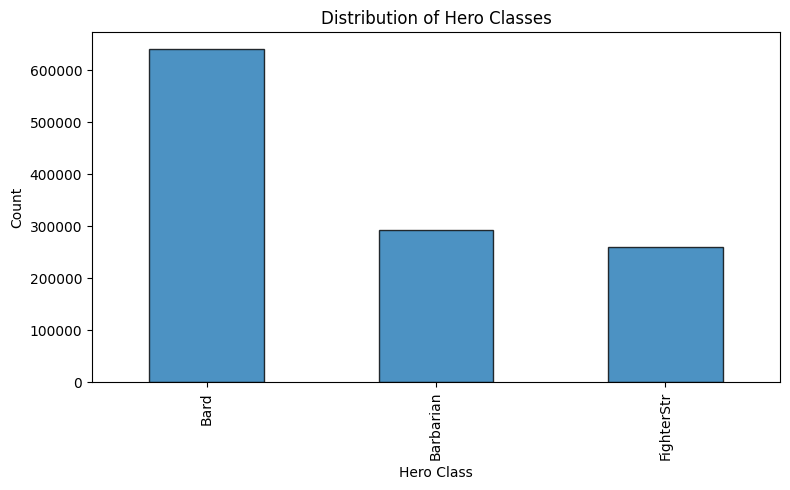

In [17]:
# 5.A. Distribution of Hero Classes
plt.figure(figsize=(8, 5))
class_counts = heros_pd["class"].value_counts()
class_counts.plot(kind="bar", edgecolor='black', alpha=0.8)
plt.title("Distribution of Hero Classes")
plt.xlabel("Hero Class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

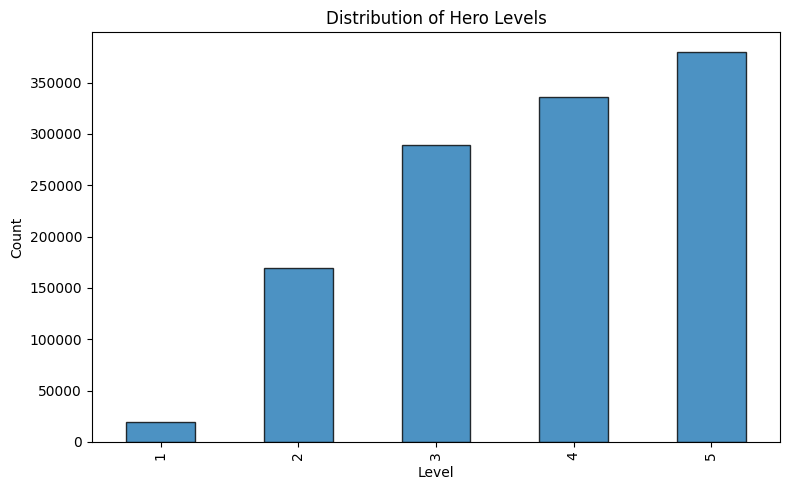

In [18]:
plt.figure(figsize=(8, 5))
level_counts = heros_pd["level"].value_counts().sort_index()
level_counts.plot(kind="bar", edgecolor='black', alpha=0.8)
plt.title("Distribution of Hero Levels")
plt.xlabel("Level")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


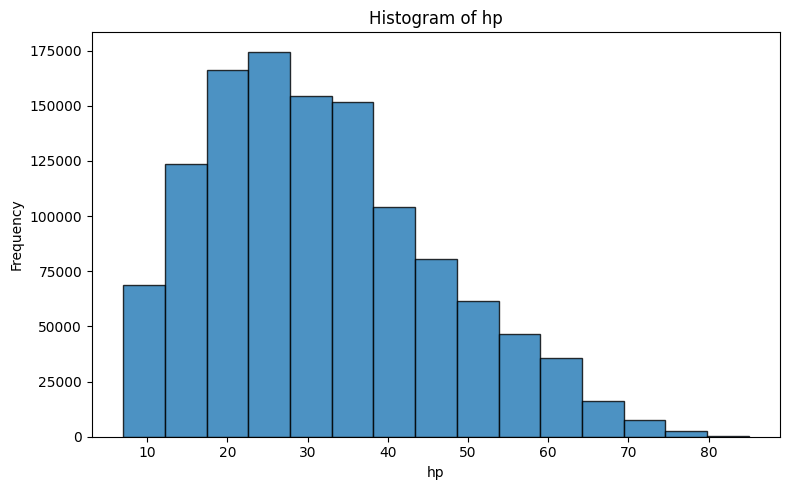

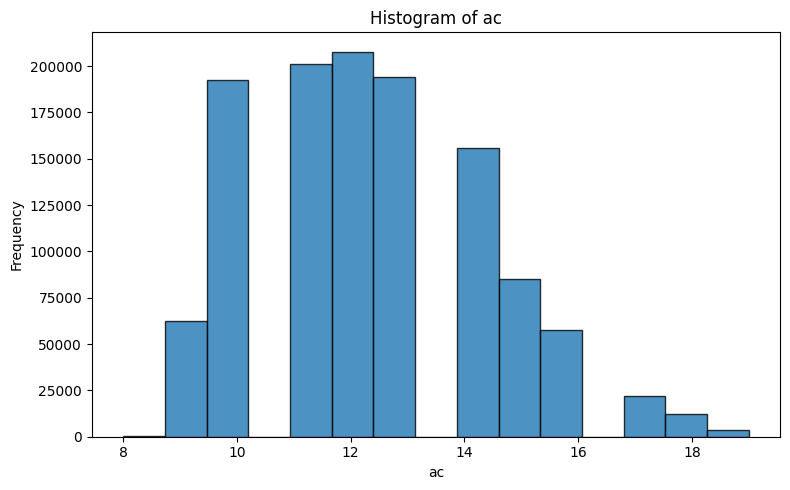

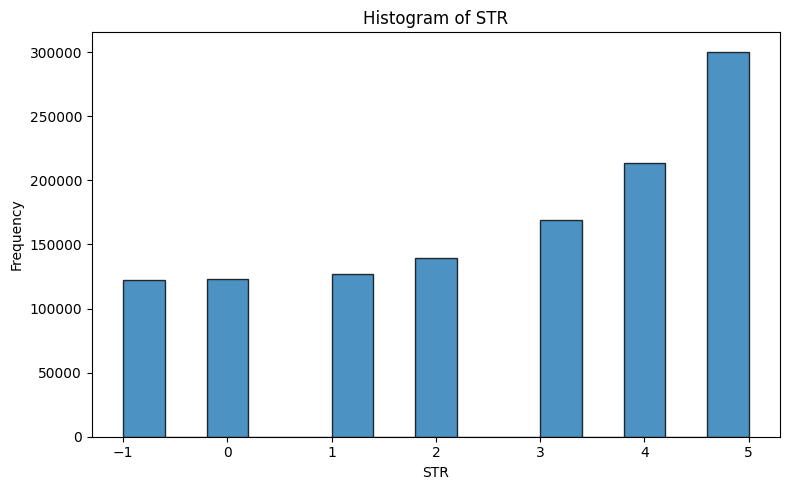

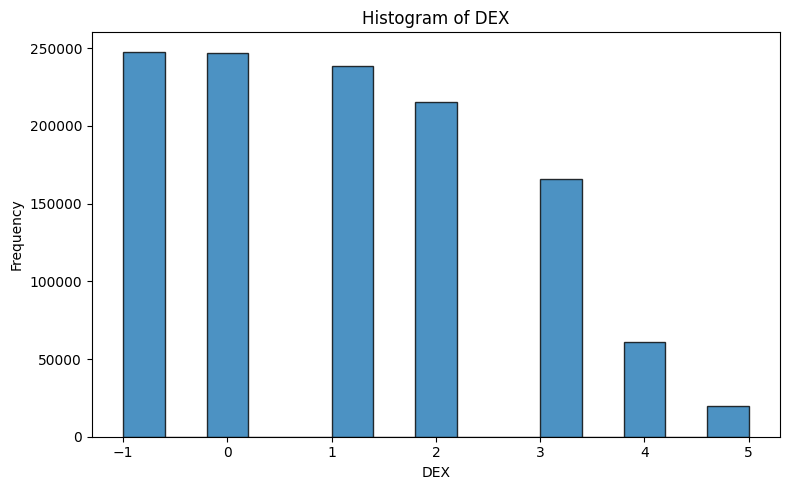

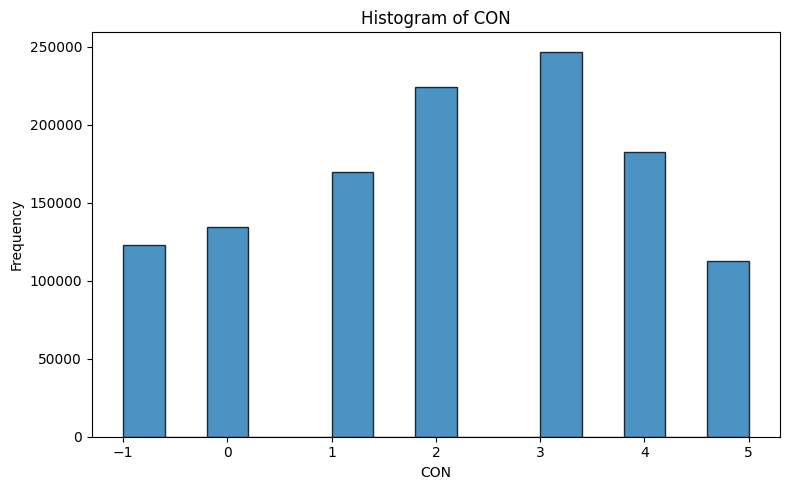

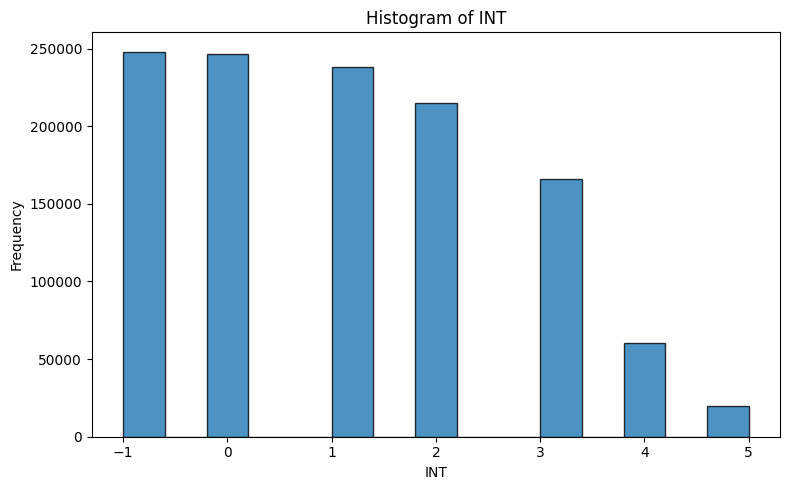

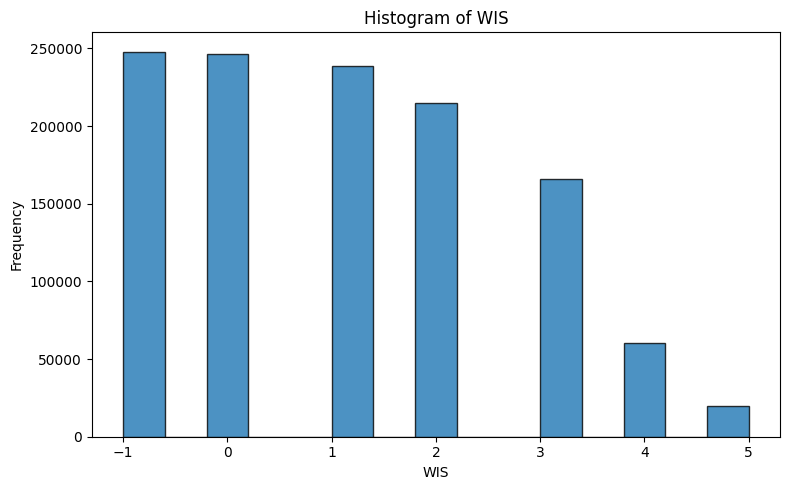

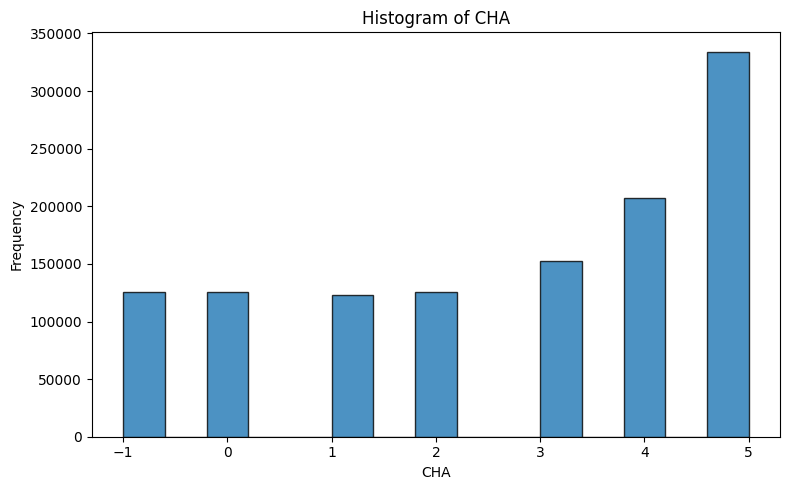

In [19]:
numeric_attrs = ["hp", "ac", "STR", "DEX", "CON", "INT", "WIS", "CHA"]
for attr in numeric_attrs:
    plt.figure(figsize=(8, 5))
    plt.hist(heros_pd[attr].dropna(), bins=15, edgecolor='black', alpha=0.8)
    plt.title(f"Histogram of {attr}")
    plt.xlabel(attr)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

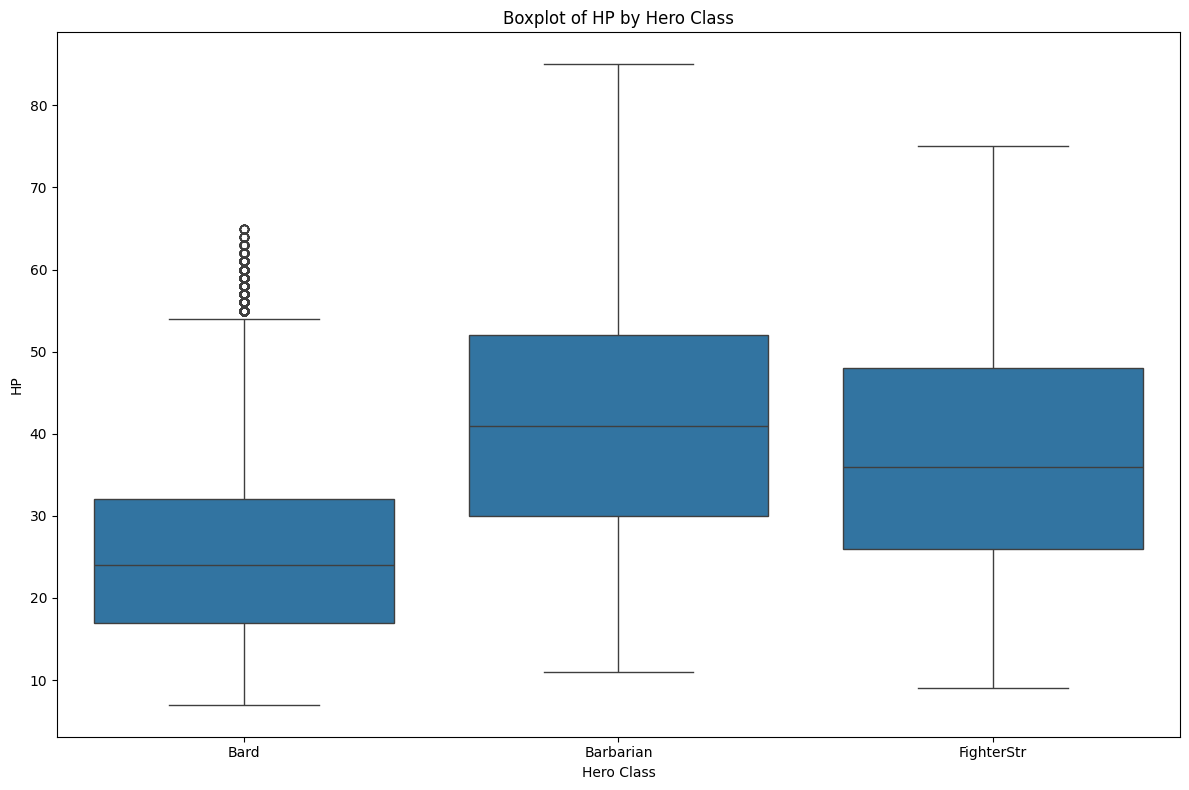

In [20]:

plt.figure(figsize=(12, 8))
sns.boxplot(data=heros_pd, x="class", y="hp")
plt.title("Boxplot of HP by Hero Class")
plt.xlabel("Hero Class")
plt.ylabel("HP")
plt.tight_layout()
plt.show()

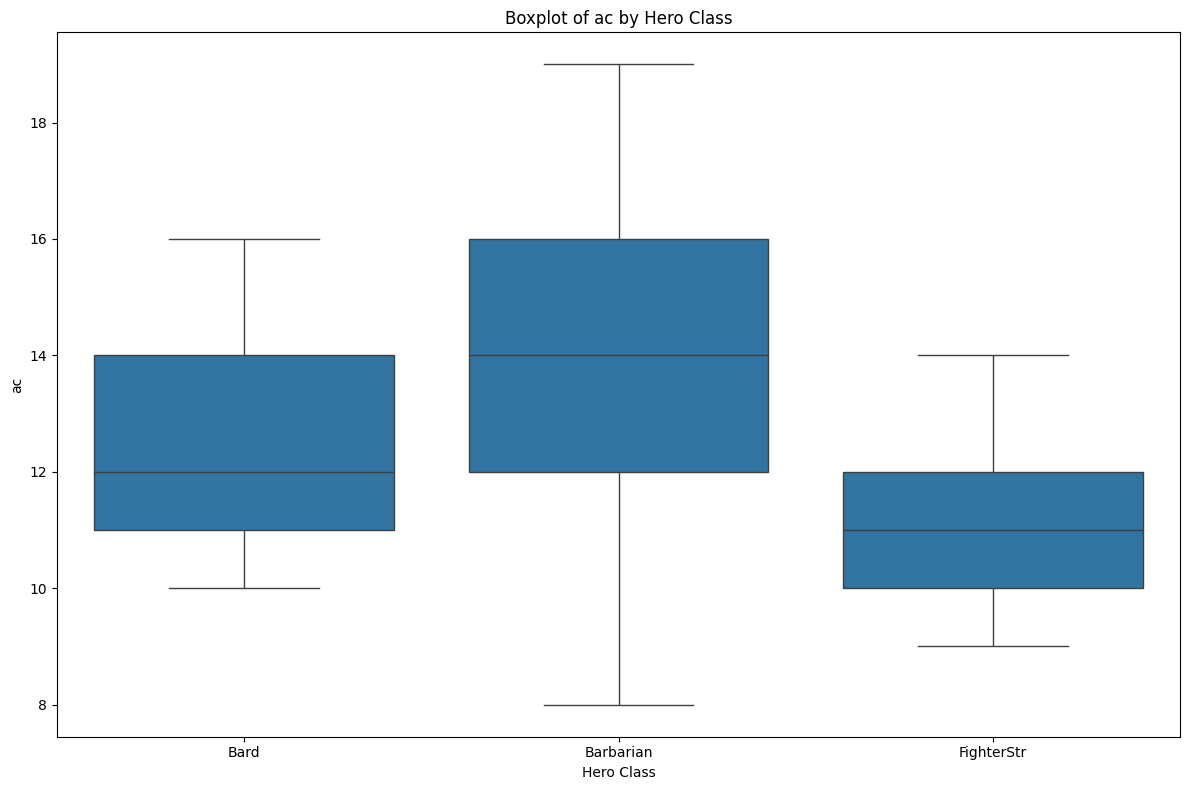

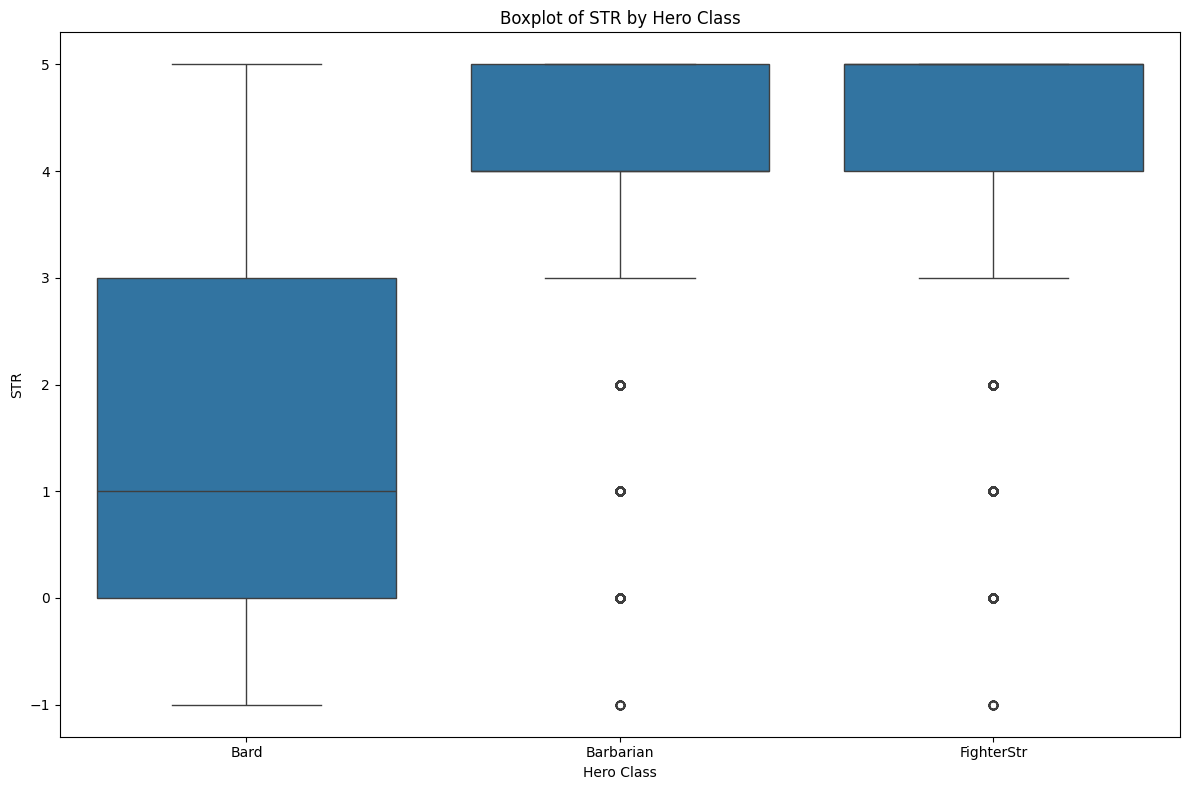

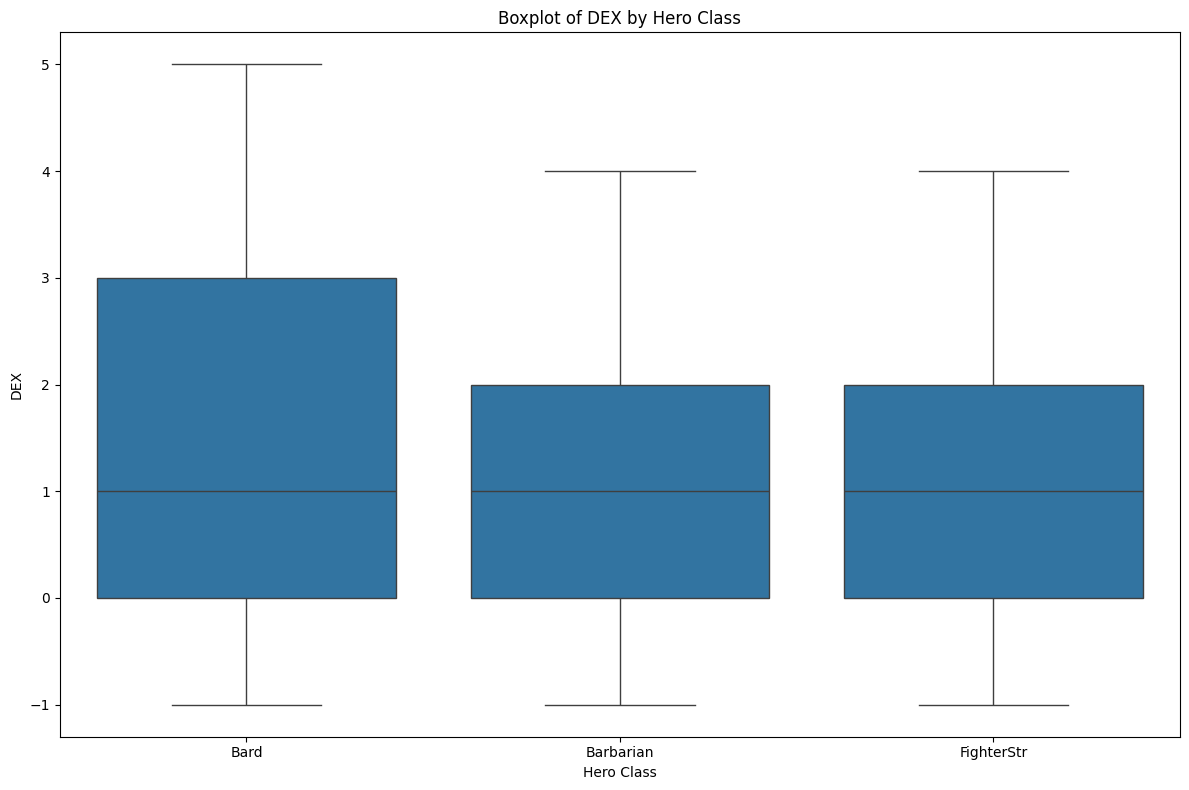

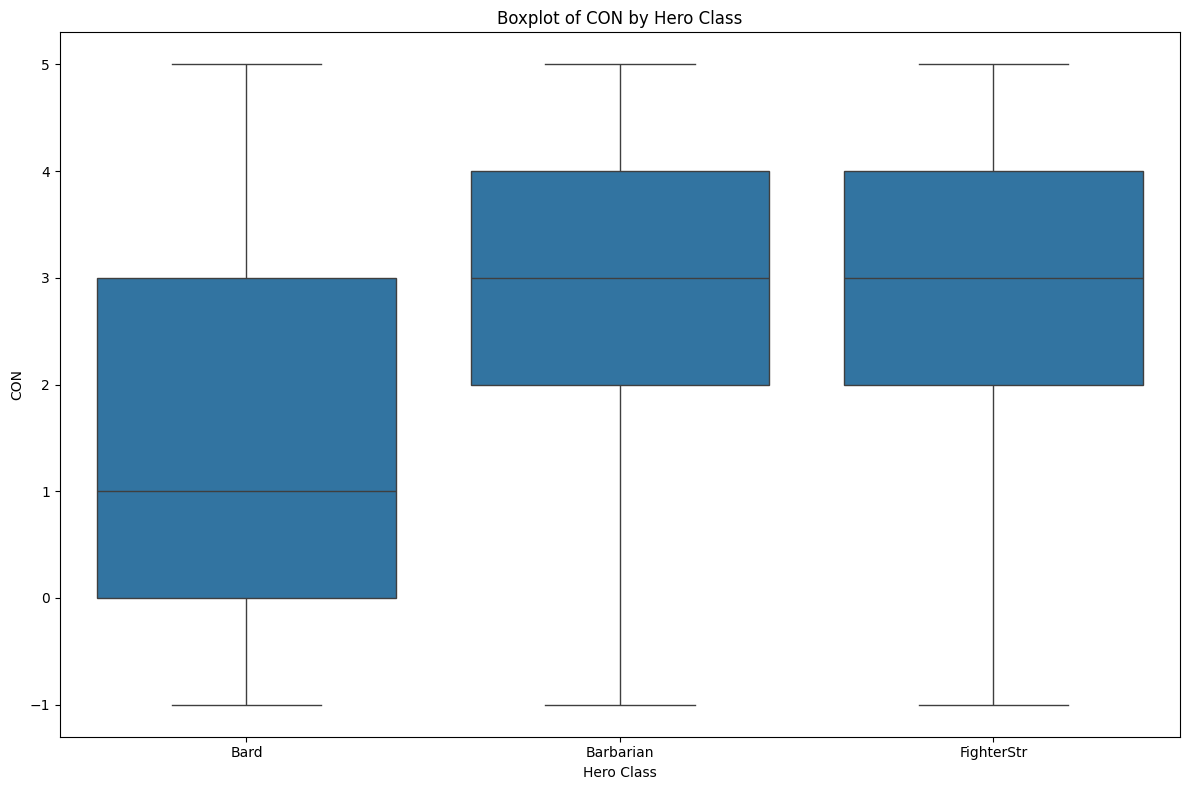

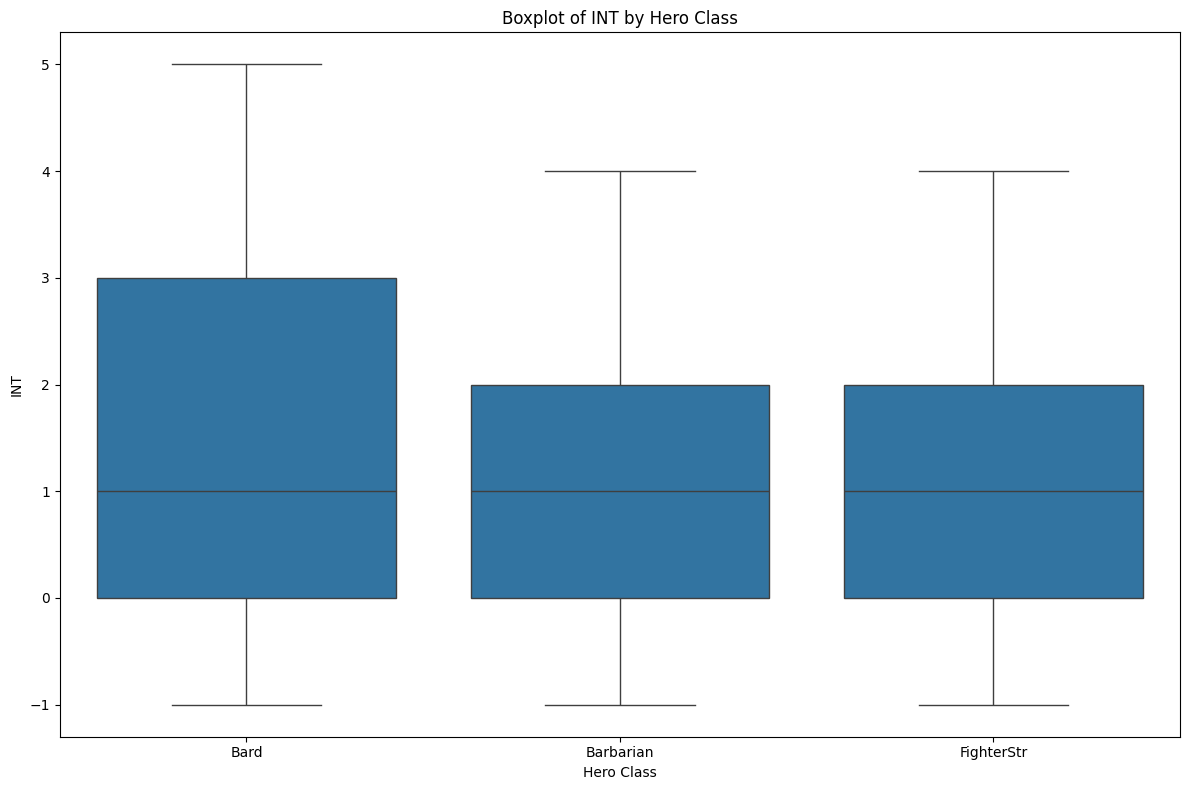

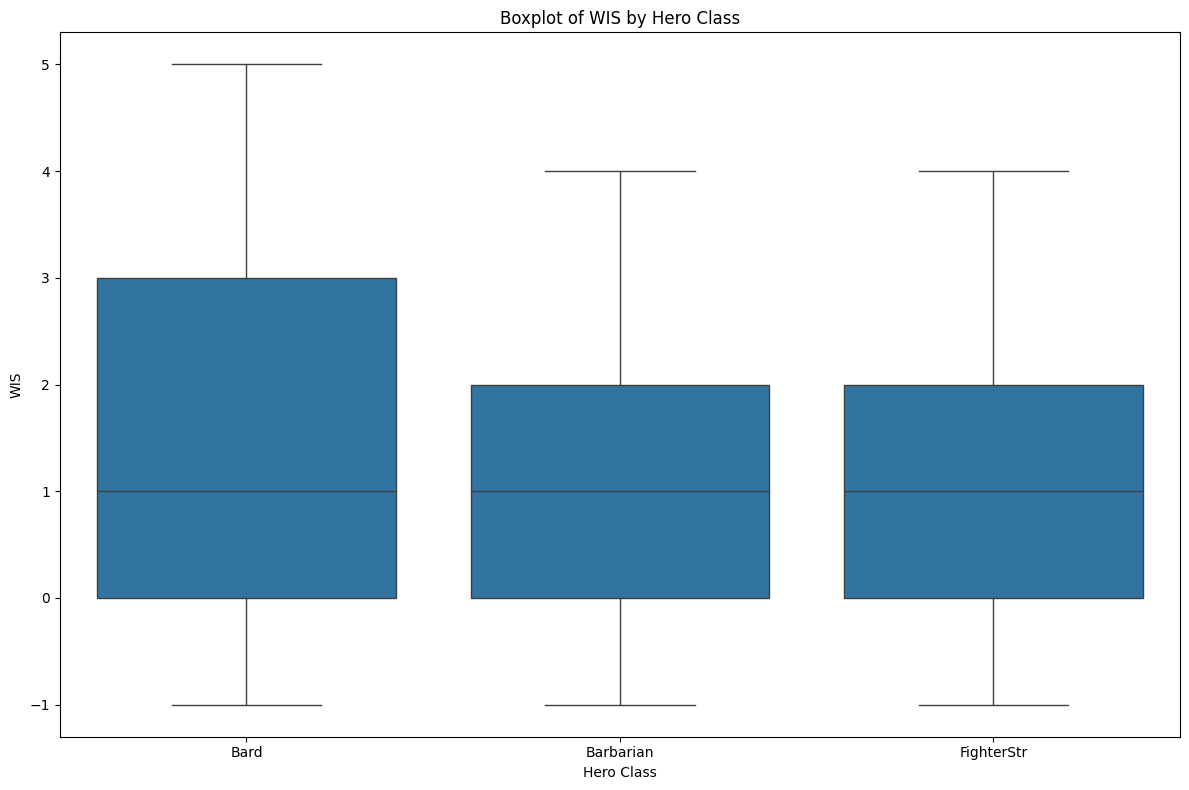

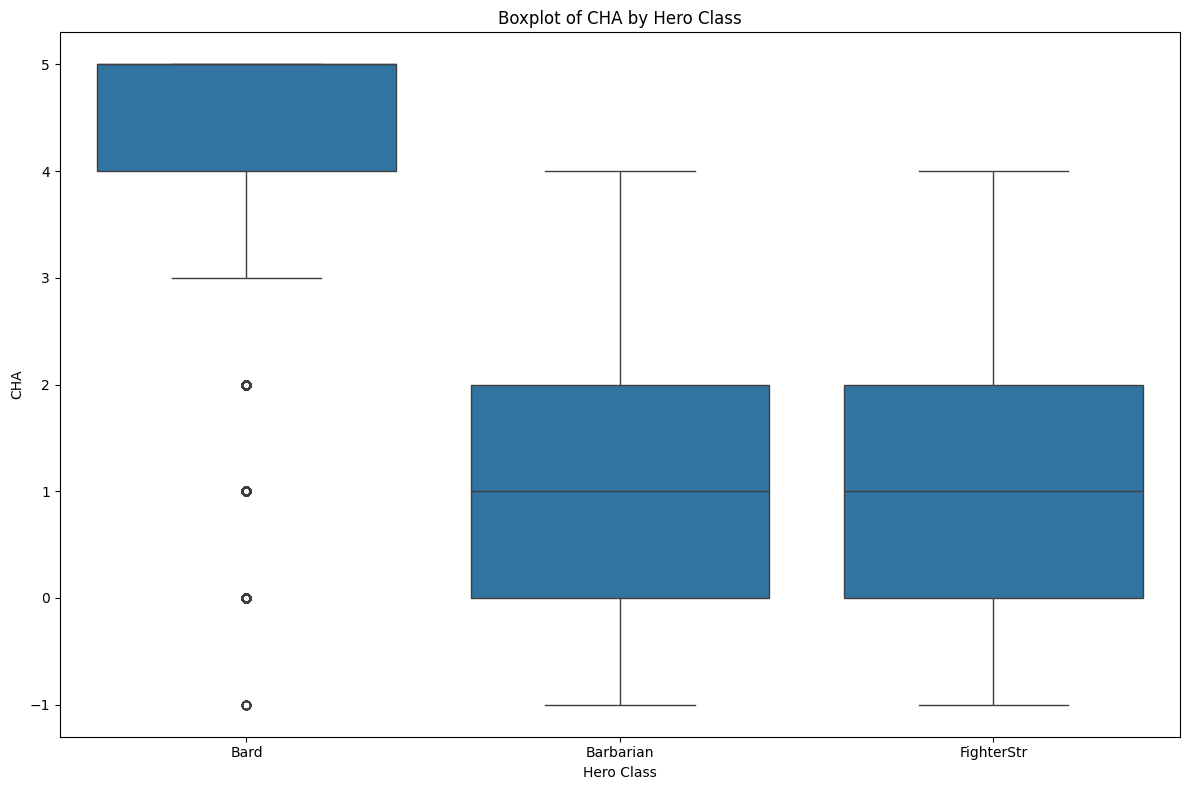

In [21]:
for attr in numeric_attrs[1:]:  # Exclude HP, already plotted
    plt.figure(figsize=(12, 8))
    sns.boxplot(data=heros_pd, x="class", y=attr)
    plt.title(f"Boxplot of {attr} by Hero Class")
    plt.xlabel("Hero Class")
    plt.ylabel(attr)
    plt.tight_layout()
    plt.show()

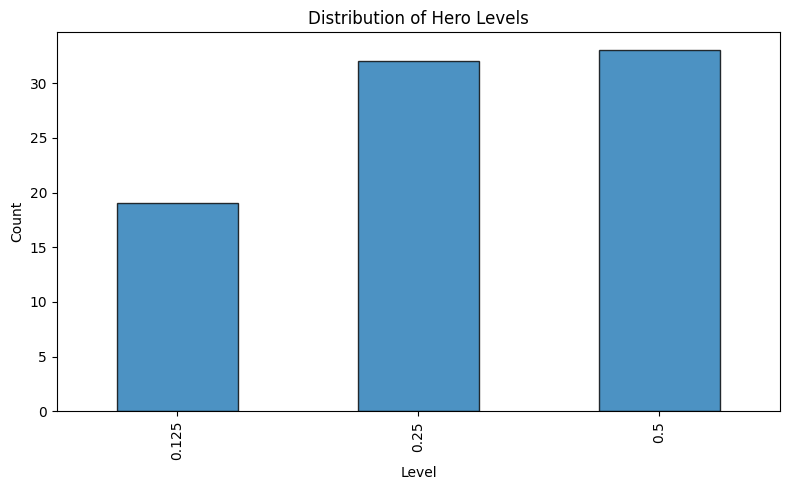

In [22]:
plt.figure(figsize=(8, 5))
level_counts = monsters_pd["cr"].value_counts().sort_index()
level_counts.plot(kind="bar", edgecolor='black', alpha=0.8)
plt.title("Distribution of Hero Levels")
plt.xlabel("Level")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


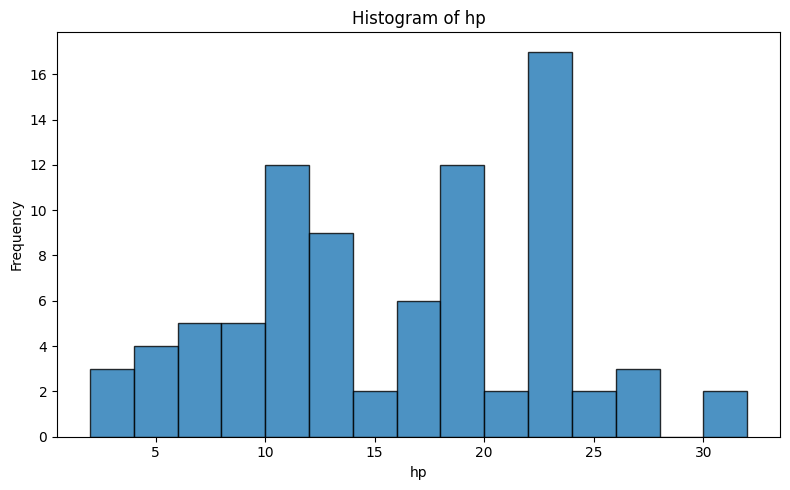

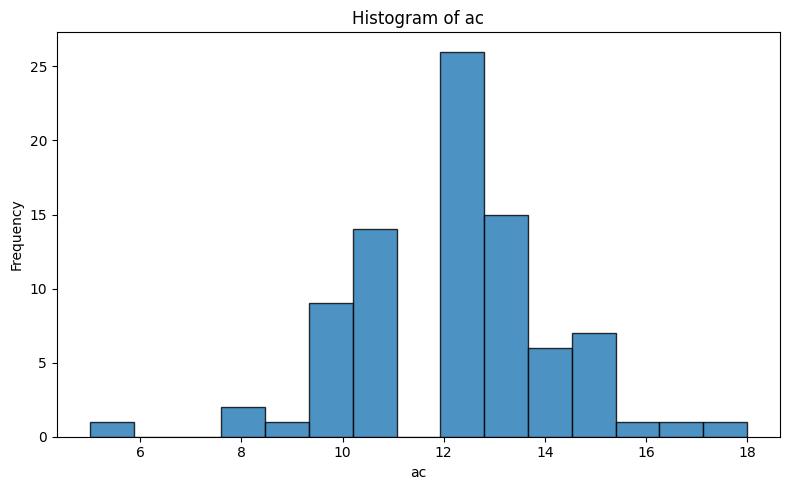

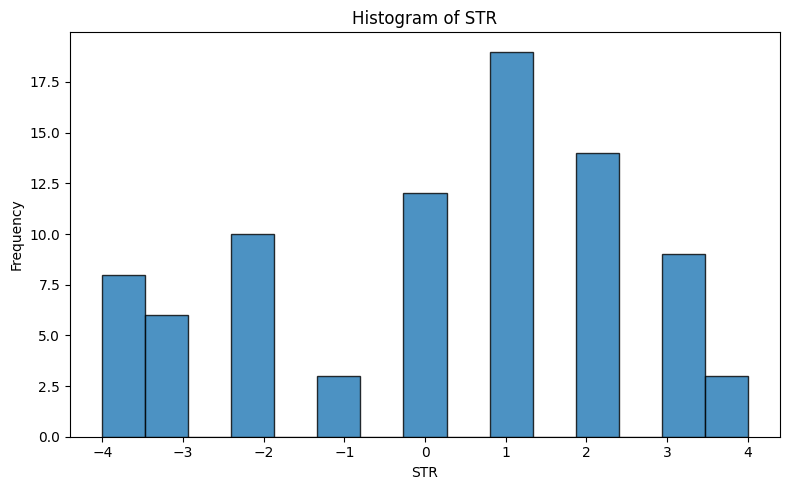

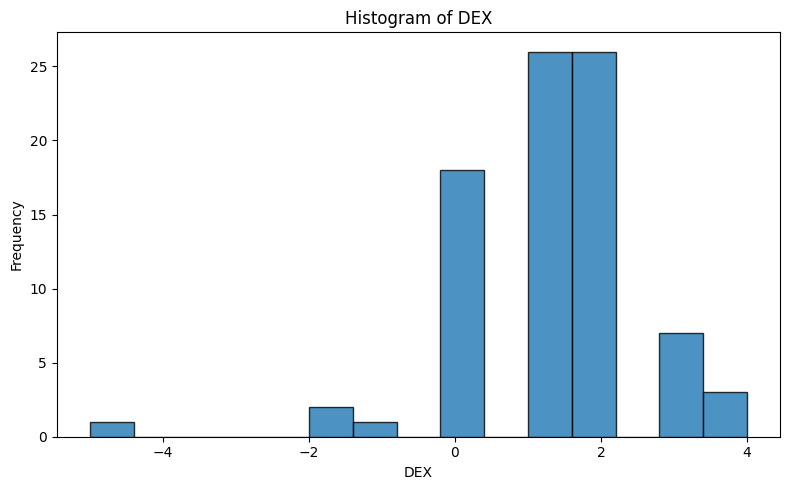

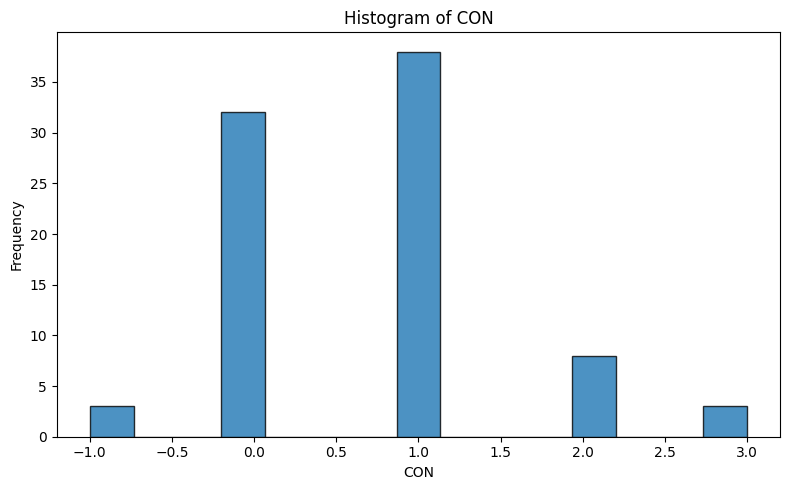

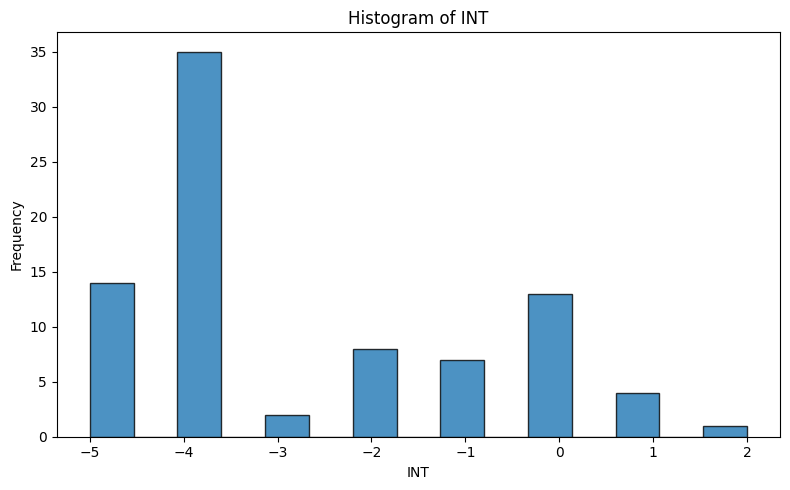

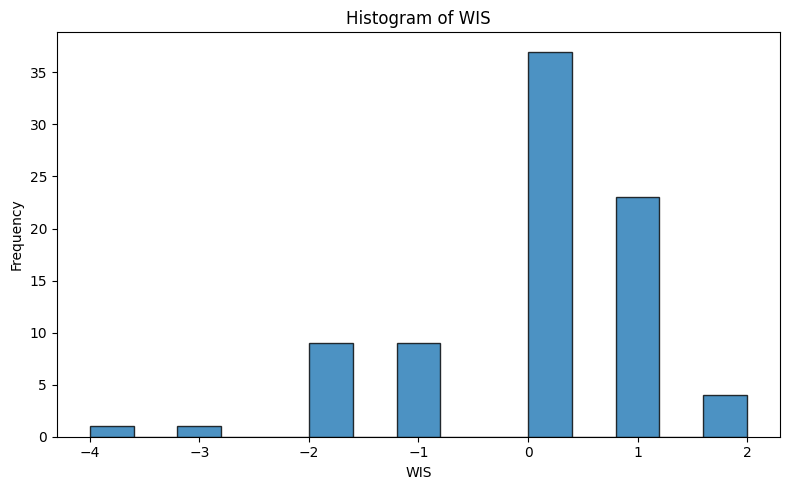

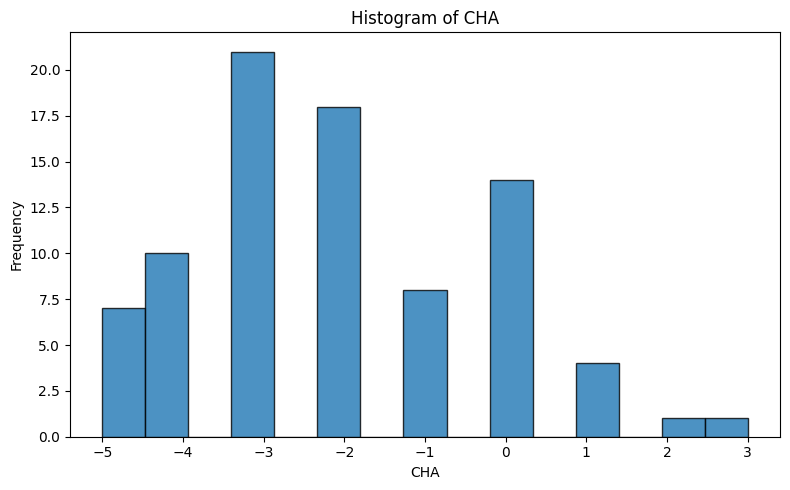

In [23]:
numeric_attrs = ["hp", "ac", "STR", "DEX", "CON", "INT", "WIS", "CHA"]
for attr in numeric_attrs:
    plt.figure(figsize=(8, 5))
    plt.hist(monsters_pd[attr].dropna(), bins=15, edgecolor='black', alpha=0.8)
    plt.title(f"Histogram of {attr}")
    plt.xlabel(attr)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

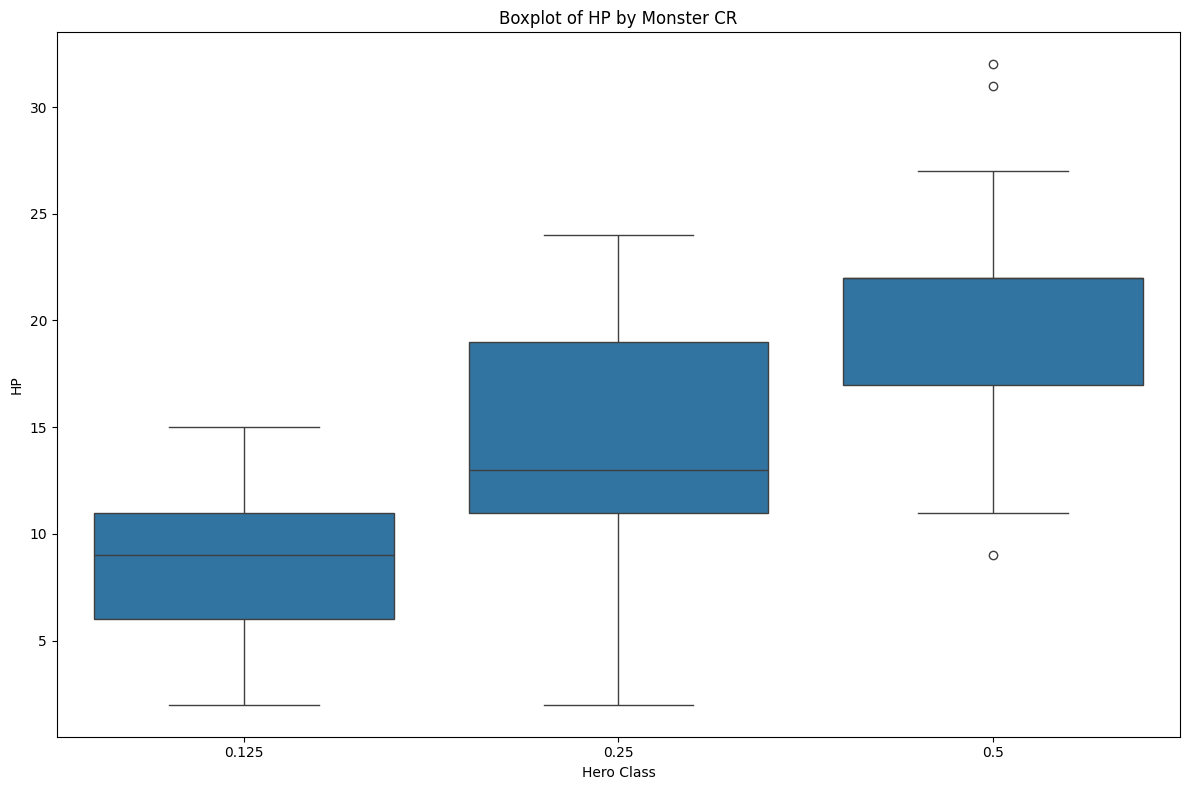

In [24]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=monsters_pd, x="cr", y="hp")
plt.title("Boxplot of HP by Monster CR")
plt.xlabel("Hero Class")
plt.ylabel("HP")
plt.tight_layout()
plt.show()

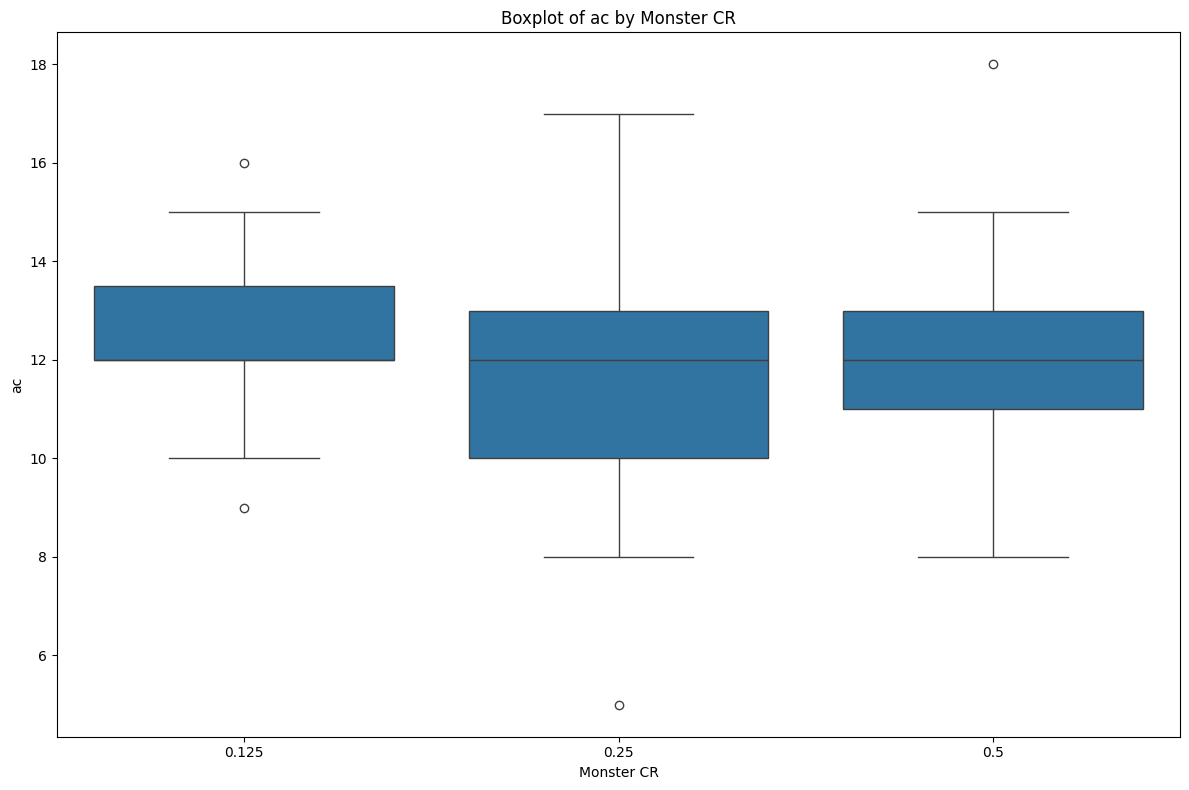

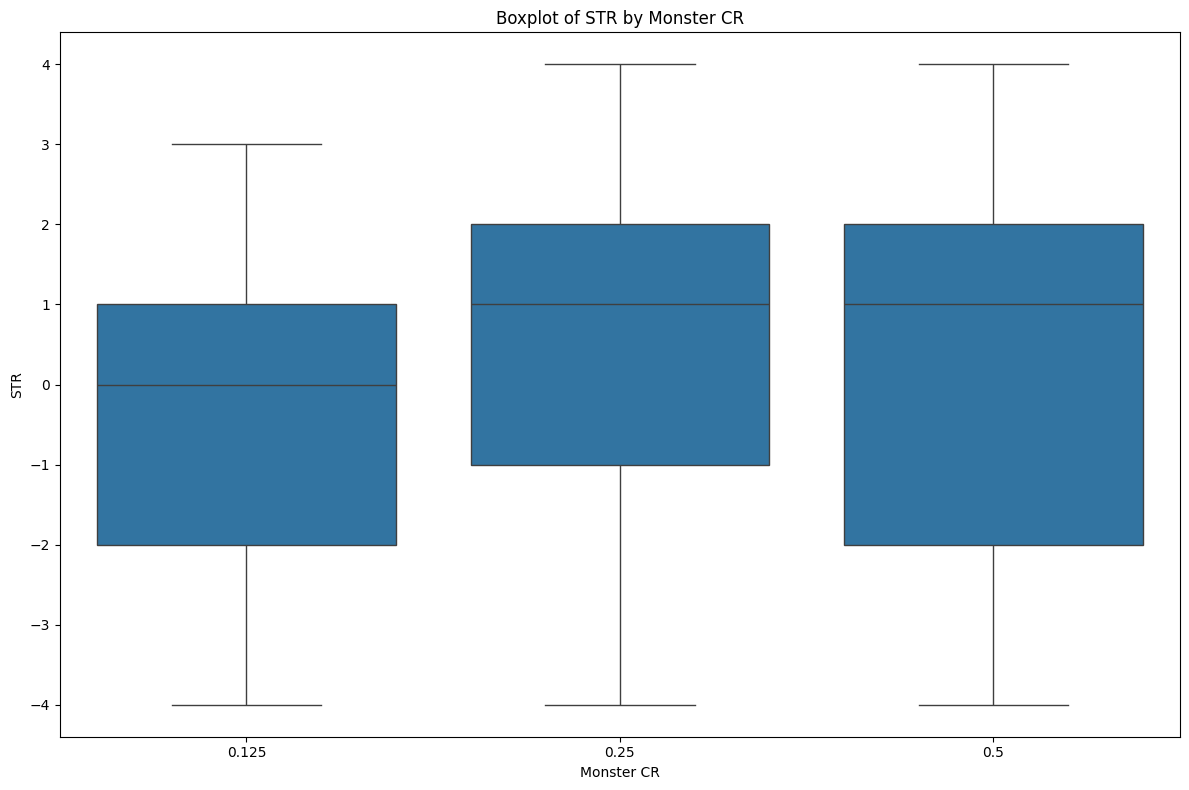

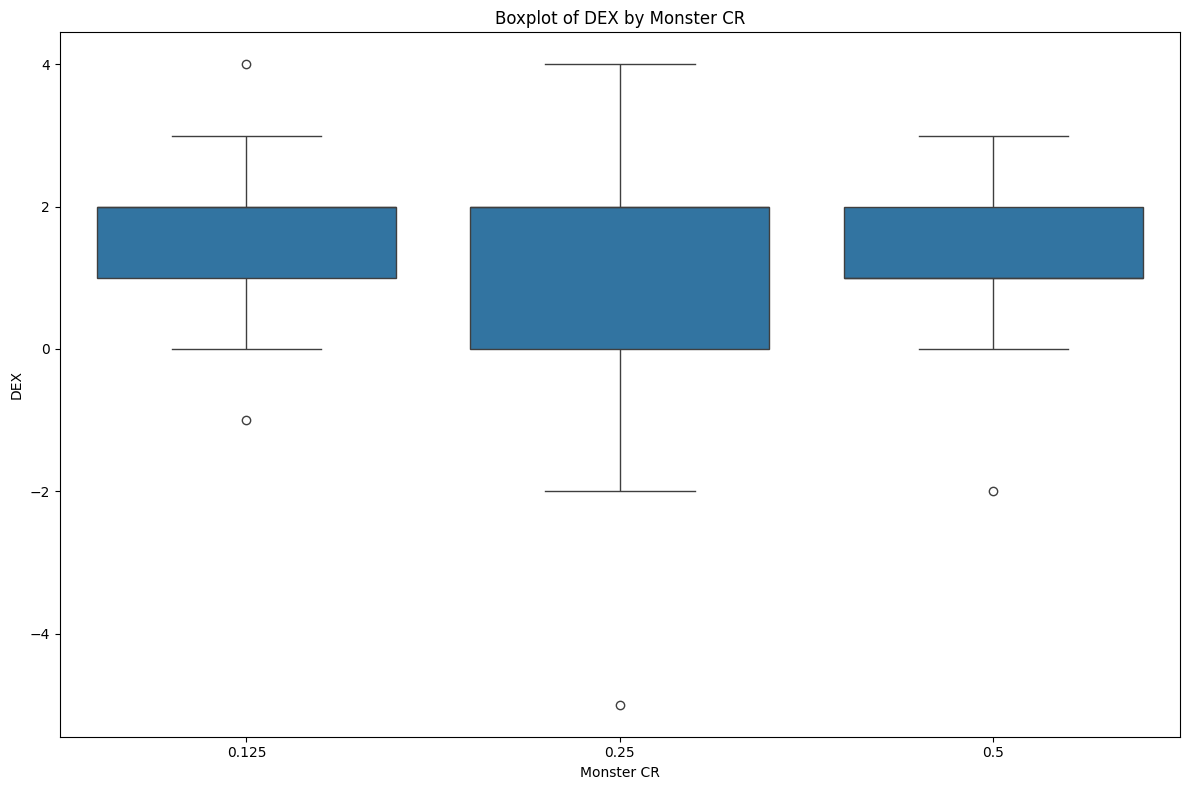

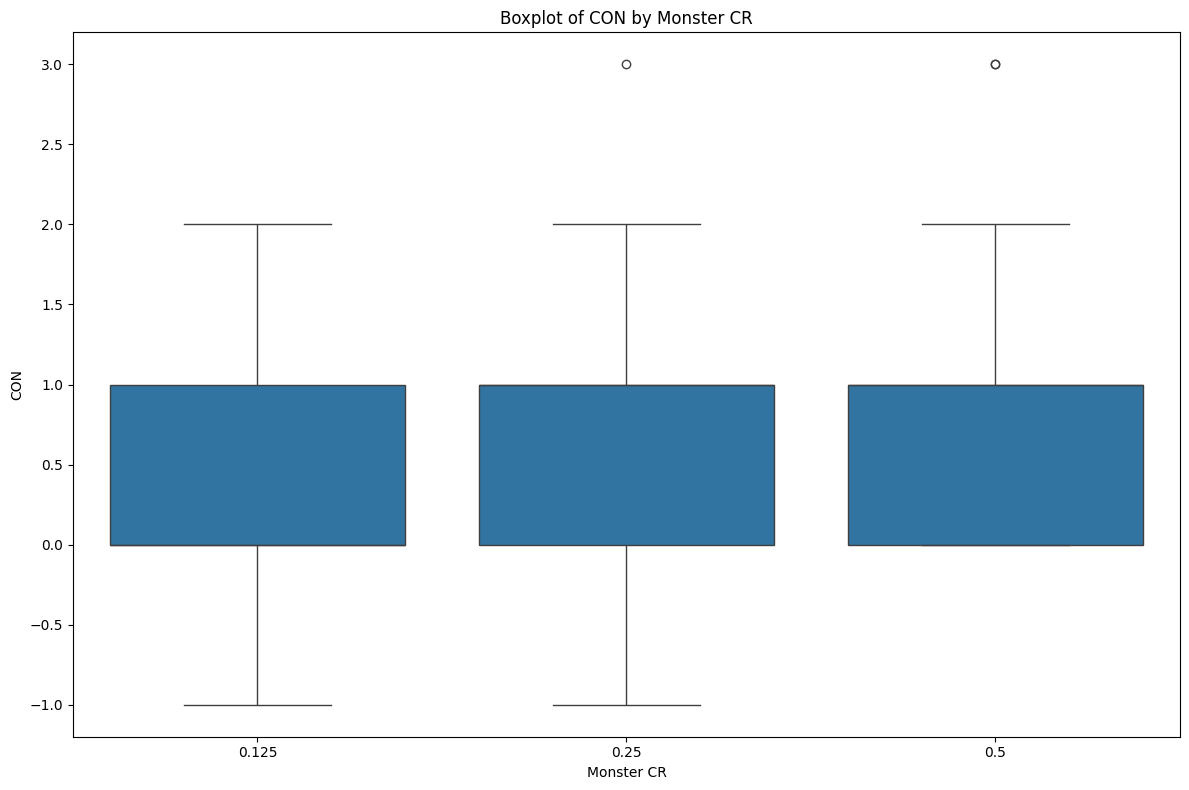

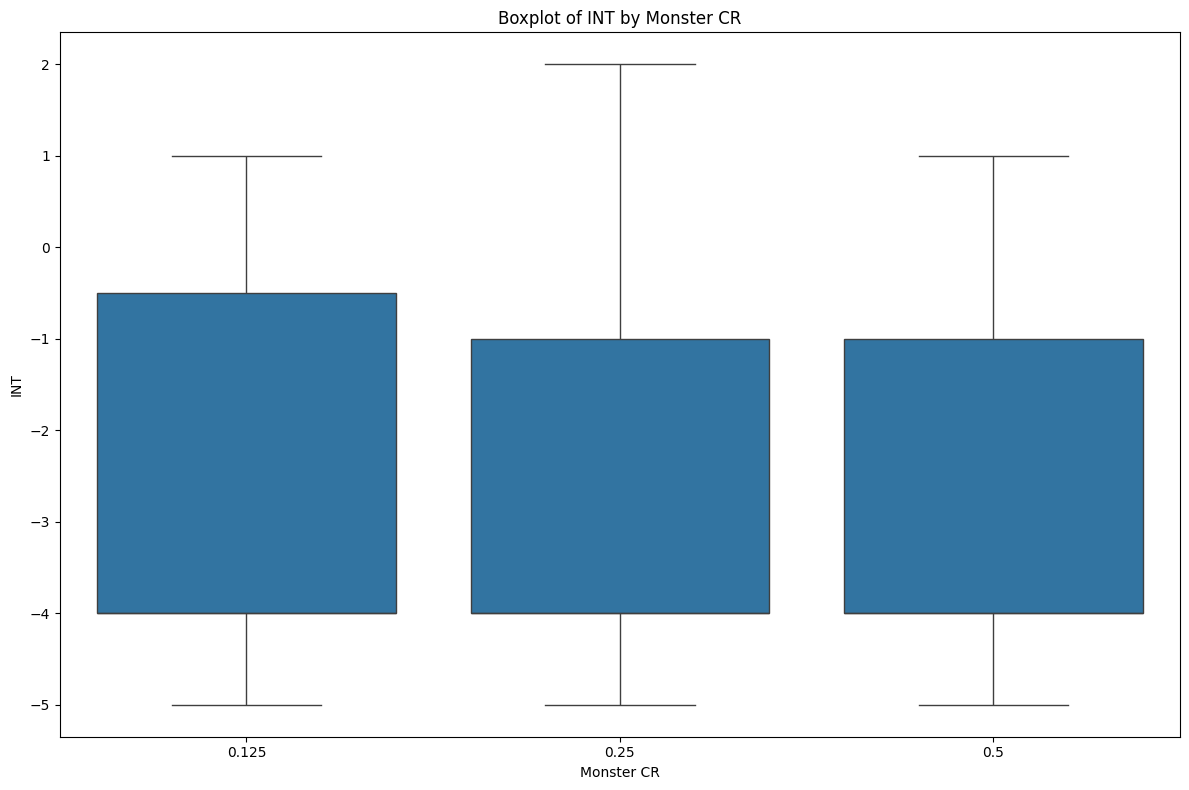

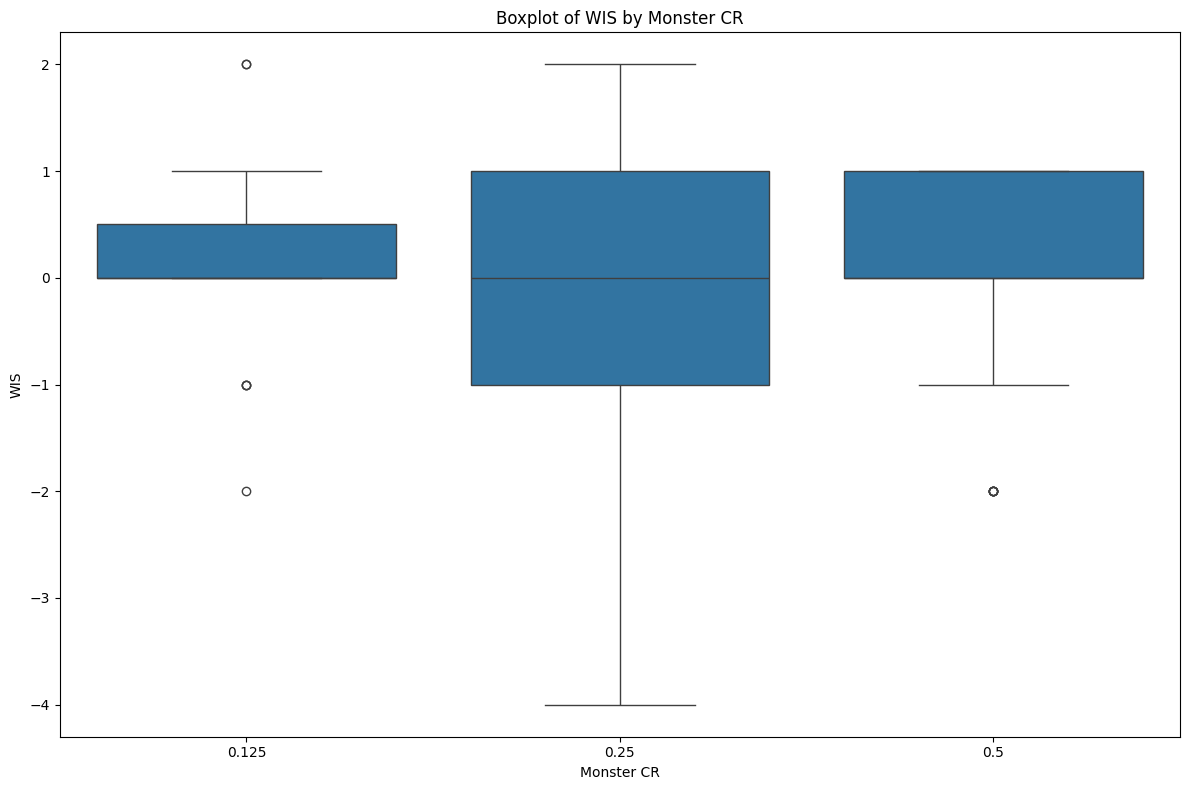

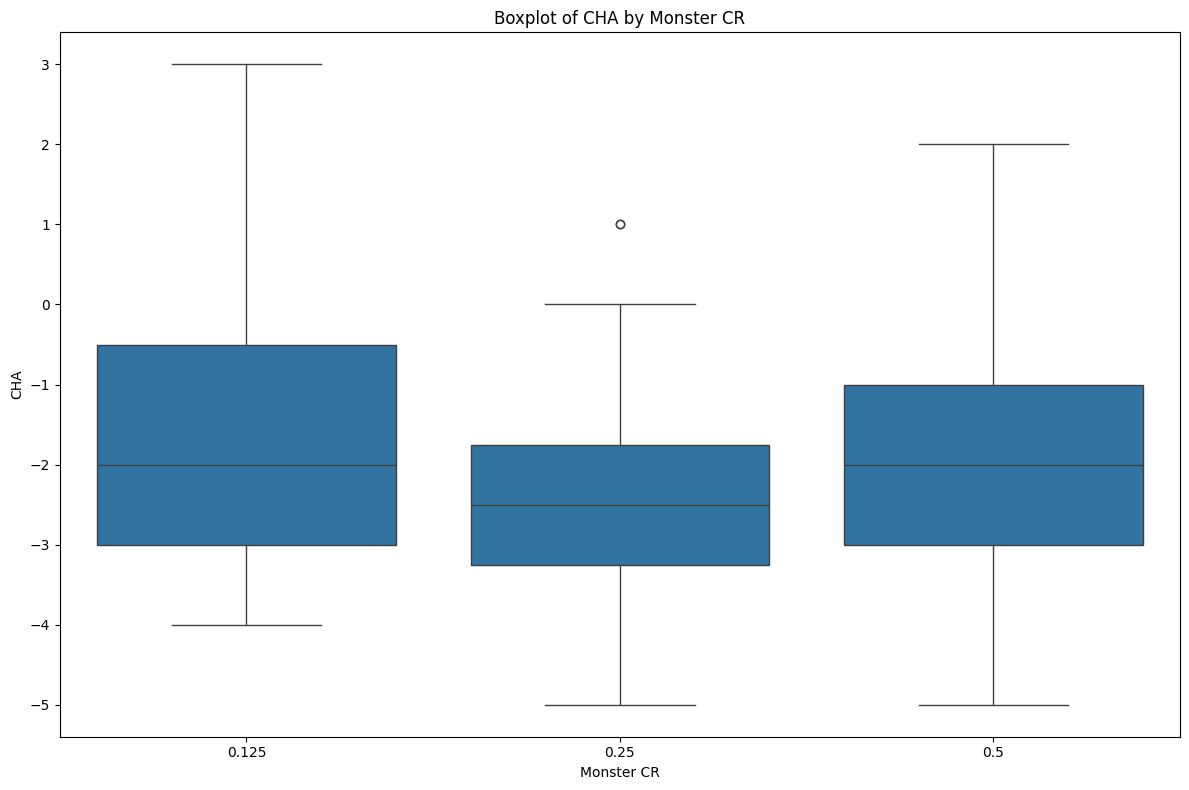

In [25]:
for attr in numeric_attrs[1:]:  # Exclude HP, already plotted
    plt.figure(figsize=(12, 8))
    sns.boxplot(data=monsters_pd, x="cr", y=attr)
    plt.title(f"Boxplot of {attr} by Monster CR")
    plt.xlabel("Monster CR")
    plt.ylabel(attr)
    plt.tight_layout()
    plt.show()

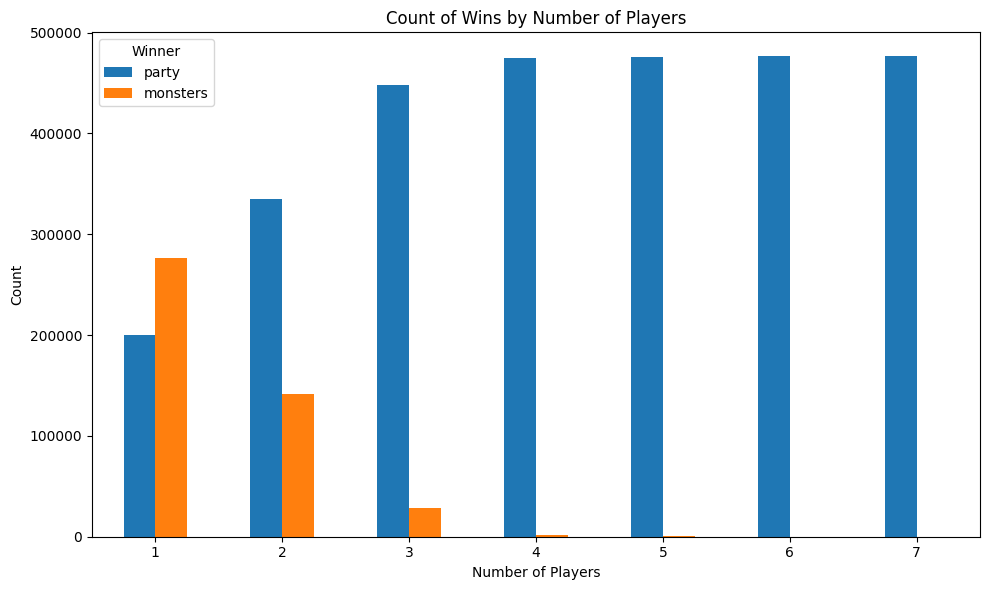

In [26]:
grouped_df = df.group_by(["num_players", "winner"]).len()

# Pivot the table so that "num_players" becomes the index and each distinct value in "winner" is placed in its own column.
# Note: We use "on" instead of the deprecated "columns" parameter.
pivot_df = grouped_df.pivot(
    index="num_players",
    on="winner",
    values="len"
).fill_null(0)

# Convert the pivoted DataFrame to a Pandas DataFrame for plotting
pivot_pd = pivot_df.sort("num_players").to_pandas()
pivot_pd = pivot_pd.set_index("num_players")

# Plot a grouped bar chart
ax = pivot_pd.plot(kind='bar', figsize=(10, 6))
ax.set_title("Count of Wins by Number of Players")
ax.set_xlabel("Number of Players")
ax.set_ylabel("Count")
ax.legend(title="Winner")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

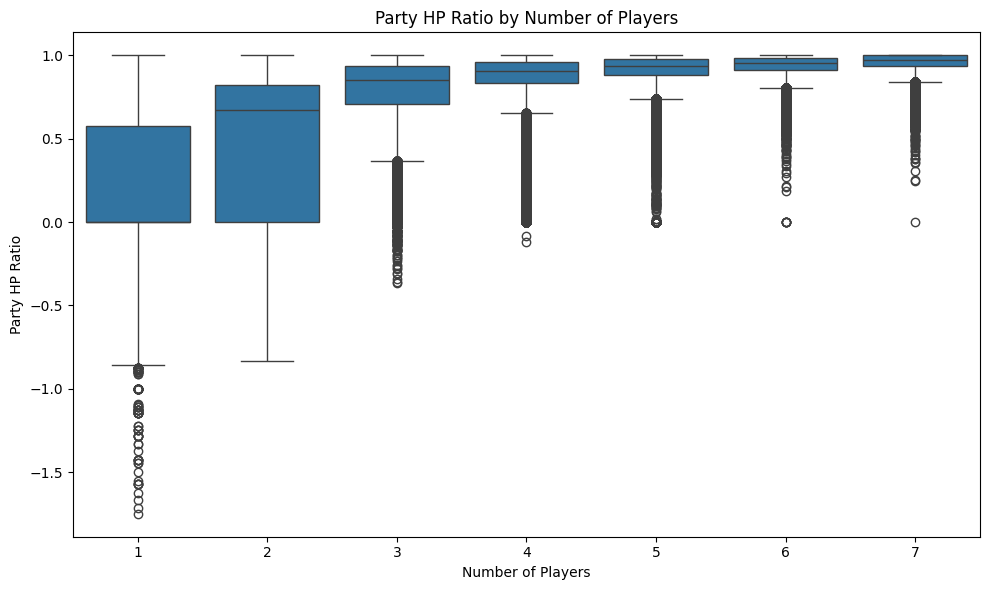

In [27]:
# Select the columns needed: num_players and party_hp_ratio
hp_df = df.select(["num_players", "party_hp_ratio"])

# Convert to Pandas
hp_pd = hp_df.to_pandas()

plt.figure(figsize=(10, 6))
sns.boxplot(x="num_players", y="party_hp_ratio", data=hp_pd)
plt.title("Party HP Ratio by Number of Players")
plt.xlabel("Number of Players")
plt.ylabel("Party HP Ratio")
plt.tight_layout()
plt.show()

In [32]:
df.write_csv(os.path.join(DATA_INTERIM_DIRECTORY, "combat_results.csv"))